Deep HW - Q3<br/>
Soroosh Noorzad - 99205372

## Table Of Contents:
* [PART A - Inception using Transfer learning](#PA)
* [PART B - Learn top model](#PB)

# PART A - Inception using Transfer learning:<a class="anchor" id="PA"></a>

In [2]:
# example of using a pre-trained model as a classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import decode_predictions, preprocess_input

# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3

# load an image from file
image = load_img('Stopwatch.jpg', target_size=(299, 299))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

# load model
model = InceptionV3()
# summarize the model
# model.summary()

# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
for i in range(3):
  # print the classification
  print('%s (%.2f%%)' % (label[0][i][1], label[0][i][2]*100))

49152/35363 [=========================================] - 0s 0us/step
stopwatch (96.34%)
scale (0.24%)
mortarboard (0.14%)


# PART B - Learn top model:<a class="anchor" id="PB"></a>

Run cell below, if and only if when the main run got exhausted.

In [ ]:
# To restrain GPU from exhausting (to free up RAM):
# Don't run this cell, if there is no need to!
from numba import cuda
device = cuda.get_current_device()
device.reset()

Main procedure:

Importing libraries.
TensorFlow version: 2.7.0
Libraries imported.

Reading data started.
Reading data finished.

Creating the model.
Model created.

Learn the model, Batch size = 40
Epoch 1/20
8/8 [==============================] - 12s 759ms/step - loss: 0.4907 - accuracy: 0.7688 - val_loss: 0.2193 - val_accuracy: 0.9375
Epoch 2/20
8/8 [==============================] - 4s 476ms/step - loss: 0.1091 - accuracy: 0.9656 - val_loss: 0.0401 - val_accuracy: 1.0000
Epoch 3/20
8/8 [==============================] - 4s 556ms/step - loss: 0.0368 - accuracy: 0.9875 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 4/20
8/8 [==============================] - 4s 564ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - 4s 557ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/20
8/8 [==============================] - 4s 478ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0041

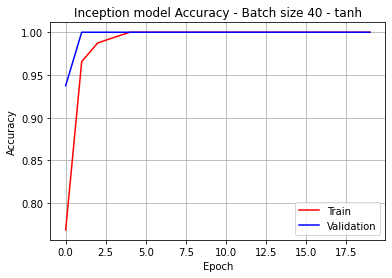


Plot the Loss Curves


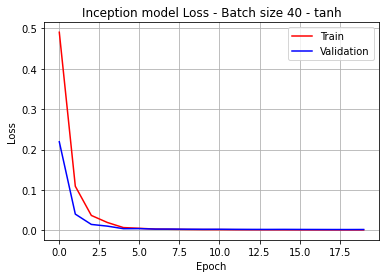


Test the model:
13/13 [==============================] - 5s 288ms/step - loss: 0.1161 - accuracy: 0.9675
Test Loss: 0.11607886105775833 , Test Accuracy: 0.9674999713897705

Plot Confusion Matrix:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       200
           1       0.95      0.99      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



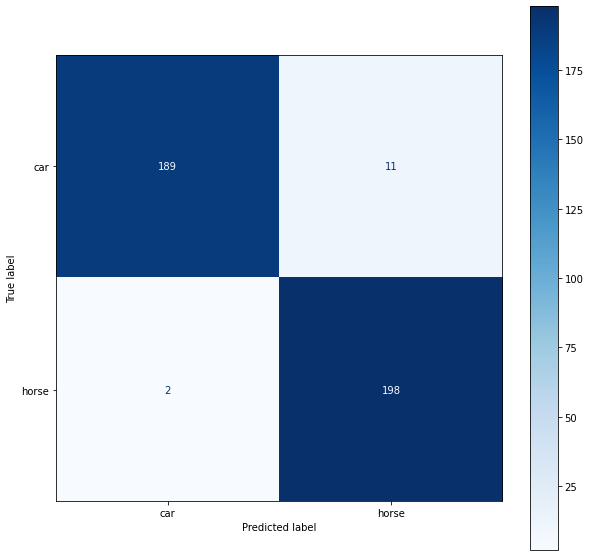

Job is done. learning time: 88 seconds


In [7]:
# Import TF and other requirements
print("Importing libraries.")
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras import datasets, layers, models, Sequential, optimizers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Import General libraries
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import random
import time
import ssl
import os

# Read Data
from six.moves import cPickle as pickle
from keras.datasets import cifar10
import seaborn as sns

# Draw Flow chart
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

# example of using a pre-trained model as a classifier
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.inception_v3 import decode_predictions, preprocess_input
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model

# example of loading the inception v3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3

print("Libraries imported.\n")

# Creating directories if not exist.
from pathlib import Path
Path("figs").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)

# Defines:
question_part = "Q3PB"
model_type = "Inception"

# Hyper-Parameters
num_training=49000
num_validation=1000
num_test=10000
# database path
data_path = 'cifar10'
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
target_labels = [1, 7]

# Optimizer type: sgd, adam
opt_type = 'sgd'
# train and test samples to learn and evaluate
tr_smp = 200
te_smp = 200
# Batch Size:
bs = int(tr_smp/5)
# Activation Function:
act_func = 'tanh'
# Epoch count:
ep_count = 20
# Loss metric:
loss_metric = 'categorical_crossentropy'

def model_plotter(model_history, metric, model_name, b_s, a_f):
    plt.figure()
    plt.plot(model_history.history[metric.lower()],'r')
    plt.plot(model_history.history['val_'+metric.lower()],'b')
    plt.title(model_name + ' model ' + metric.capitalize() + " - Batch size " + str(b_s) + " - " + a_f)
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()
    plt.savefig("figs/" + question_part + "_" + model_name + "_" + metric.lower() + "_" + str(b_s) + "_" + a_f + ".png")
    plt.show()

def read_data(path='cifar10'):
    xs = []
    ys = []
    for b in range(1,6):
        # load single batch of cifar
        filename = os.path.join(path, 'data_batch_%d' % (b, ))
        with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding='latin1')
            X = datadict['data'].reshape(10000, 3072)
            Y = np.array(datadict['labels'])
        xs.append(X)
        ys.append(Y)

    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    with open(os.path.join(path, 'test_batch'), 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        Xte = datadict['data'].reshape(10000, 3072)
        Yte = np.array(datadict['labels'])
    
    # Subsample the data
    r_val = range(num_training, num_training + num_validation)
    r_tr = range(num_training)
    r_te = range(num_test)
    x_val = Xtr[r_val].astype('float32')/255.0
    y_val = Ytr[r_val]

    # We can split data here, but we don't want.
    # x_train = Xtr[r_tr].astype('float32')/255.0
    # y_train = Ytr[r_tr]
    x_train = Xtr.astype('float32')/255.0
    y_train = Ytr

    x_test = Xte[r_te].astype('float32')/255.0
    y_test = Yte[r_te]
    return x_train, y_train, x_val, y_val, x_test, y_test

print("Reading data started.")
read_data_online = True
if read_data_online:
    # Read data, using Keras (Needs download):
    ssl._create_default_https_context = ssl._create_unverified_context
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    r_val = range(num_training, num_training + num_validation)
    r_tr = range(num_training)
    r_te = range(num_test)

    x_val = x_train[r_val].astype('float32')/255.0
    y_val = y_train[r_val]
    # x_train = x_train[r_tr].astype('float32')/255.0
    x_train = x_train.astype('float32')/255.0
    # y_train = y_train[r_tr]
    x_test = x_test[r_te].astype('float32')/255.0
    y_test = y_test[r_te]
    xtr_img = x_train
    xte_img = x_test
else:
    # Read data, using the defined function (locally - Downloaded file):
    x_train, y_train, x_val, y_val, x_test, y_test = read_data(data_path)
    xtr_img = x_train.reshape(len(x_train), 3, 32, 32).transpose([0, 2, 3, 1])
    xte_img = x_test.reshape(len(x_test), 3, 32, 32).transpose([0, 2, 3, 1])

def divider(data, lbl_data, lbls, smp_cnt):
  lbl_idx = []
  lbl_smp_idx = []
  x = []
  for lbl in lbls:
    lbl_idx.append(np.where(lbl_data == lbl))
  for i, lbl in enumerate(lbls):
    lbl_smp_idx.append(random.sample(lbl_idx[i][0].tolist(), smp_cnt))
  for i, _ in enumerate(lbls):
    if i == 0:
      x = np.asarray(data[lbl_smp_idx[0]])
    else:
      x = np.append(x, data[lbl_smp_idx[i]], axis=0)
  return x, lbl_idx, lbl_smp_idx

def resized_images_generator(pics):
  res = []
  for image in pics:
    res.append(tf.image.resize(image, (299, 299)))
  return res

x_tr, _, _ = divider(x_train, y_train, target_labels, tr_smp)  # 4: Deer 7: Horse
x_tr = resized_images_generator(x_tr)
# x_tr = tf.image.resize(x_tr, (299, 299))

x_te, _, _ = divider(x_test, y_test, target_labels, te_smp)  # 4: Deer 7: Horse
x_te = resized_images_generator(x_te)
# x_te = tf.image.resize(x_te, (299, 299))

# Making classes one hot for the sake of model training:
y = np.array([[0]]*tr_smp+[[1]]*tr_smp)
y_one_hot = tf.keras.utils.to_categorical(y, 2)


# Shuffle data
indices = tf.range(start=0, limit=tf.shape(x_tr)[0], dtype=tf.int32)
idx = tf.random.shuffle(indices)
x_tr = tf.gather(x_tr, idx)
x_te = tf.gather(x_te, idx)
y = tf.gather(y, idx)
y_one_hot = tf.gather(y_one_hot, idx)

print("Reading data finished.")



print("\nCreating the model.")

# load model
base_model = InceptionV3(weights='imagenet',input_shape=(299, 299, 3), include_top=False)

# first: train only the top layers
# i.e. freeze all convolutional InceptionV3 layers
# base_model.trainable = False        # First way
for layer in base_model.layers:   # Second way:
    layer.trainable = False


top_model = base_model.output
# top_model = layers.Flatten(name='flatten')(top_model)
# # add a global spatial average pooling layer
top_model = layers.GlobalAveragePooling2D()(top_model)
# let's add a fully-connected layer
top_model = layers.Dense(128, activation='relu')(top_model)
top_model = layers.Dense(128, activation='relu')(top_model)
# and a logistic layer -- let's say we have 200 classes
predictions = layers.Dense(2, activation='softmax')(top_model)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# compile the model (should be done *after* setting layers to non-trainable)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, name="SGD")
model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])
# model.summary()
print("Model created.\n")

print("Learn the model, Batch size =", bs)
t = time.time()
model_learning = model.fit(x_tr, y_one_hot, epochs = ep_count, batch_size=bs, validation_split=0.2, shuffle=True)
t = time.time()-t

print("\nPlot the Accuracy Curves")
model_plotter(model_learning, 'accuracy', model_type, bs, act_func)

print("\nPlot the Loss Curves")
model_plotter(model_learning, 'loss', model_type, bs, act_func)

model.save("models/cifar10_" + question_part + "_" + model_type + "_bs" + str(bs) + "_" + act_func + ".h5")

# Model Testing:
print("\nTest the model:")
model_test_result = model.evaluate(x_te, y_one_hot)
print("Test Loss:", model_test_result[0], ", Test Accuracy:", model_test_result[1])

print("\nPlot Confusion Matrix:")
# Confusion Matrix:
y_pred_softmax = model.predict(x_te)
y_pred = [np.argmax(y) for y in y_pred_softmax]

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
plt.rcParams["figure.figsize"] = (10,10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['car', 'horse'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig("figs/" + question_part + "_" + model_type + "_confusion_" + str(bs) + "_" + act_func +  ".png")
plt.show()

print("Job is done. learning time:", int(t), "seconds")